In [9]:
import ssl
import urllib.request



import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import argparse
import os
import itertools as it
import math
import shapely
from shapely.geometry import Polygon,box
from pylibdmtx.pylibdmtx import decode

In [42]:
rea_threshold = 50*50
aspect_ratio_threshold = 7
irregularity_threshold = 0.1
adjacency_threshold = -1

In [43]:
def removeDuplicates(boxes,adjacency_threshold):
    i=0
    while i < len(boxes):
        poly1 = Polygon(boxes[i])
        j = i+1
        while j < len(boxes):
            poly2 = Polygon(boxes[j])
            if poly1.equals(poly2) or poly1.almost_equals(poly2, decimal=0.5 ): del boxes[j]
                
            else: j += 1
        i +=1
    return boxes

In [44]:
def processFrame(frame):
    
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #median blur helps to eliminate salt&pepper noise - if it lowers DataMatrix decoding accuracy, it can be changed or eliminated.
    blurred = cv2.medianBlur(image,3)

    adapt_mean = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,35,2)
        
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(6,6))
    opened = cv2.morphologyEx(adapt_mean, cv2.MORPH_OPEN, kernel) 

    blurred_new = cv2.medianBlur(opened ,5) 


    v = np.median(blurred_new)
    sigma = 0.33

    #---- Apply automatic Canny edge detection using the computed median----

    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(blurred_new, lower, upper)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    
    #adding contours
    
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    return adapt_mean,contours

In [45]:
def processContours(contours,area_threshold,aspect_ratio_threshold,irregularity_threshold,adjacency_threshold,image_h, image_w):
    rects = []
    boxes = []
    
    for i in range(len(contours)):
        approx = cv2.convexHull(contours[i])
        
        #intersection = 0
    
        contArea = cv2.contourArea(approx)
        
        #AREA THRESHOLD
        if contArea > area_threshold :
            
            #IRREGULARITY (NON-RECTANGULARITY) MEASUREMENT
            irregularity = 0
            aspect_ratio = 0
        
            rect = cv2.minAreaRect(approx)
            (x1,y1),(w1,h1),_ = rect
            
            rectArea = w1*h1
    
            irregularity = abs(rectArea-contArea)/rectArea
            
            #ASPECT RATIO MEASUREMENT
            aspect_ratio = w1/h1
            
            
            if irregularity < irregularity_threshold and 1/aspect_ratio_threshold < aspect_ratio < aspect_ratio_threshold :
                
                #SHAPE INTERACTIONS----------------------------------------------------------------------------------- 
                
                addRect = True
                j = 0
                
                box = [cv2.boxPoints(rect),[]]
                box[0] = np.int0(box[0]) 
                boxPoly1 = Polygon(box[0])
                
                while j < len(rects):
                    (x2,y2),(w2,h2),_ = rects[j]
    
                    boxPoly2 = Polygon(boxes[j][0])
                    
                    #CHECK FOR DUPLICATES AND SHAPES AT EDGES OF FRAME
                    if boxPoly1.almost_equals(boxPoly2, decimal=0) or boxPoly1.equals(boxPoly2) \
                    or not boxPoly1.within(Polygon([(1,1),(1,image_h-2),(image_w-2,image_h-2),(image_w-2,1)])):
                        addRect = False
                        break
                    
                    
                    #FIND SHAPES CONTAINED IN SHAPES
                    if boxPoly1.contains(boxPoly2):
                        print(rect,"CONTAINS",rects[j])
                        if 1.1 > w2/h2 > 0.9:
                            #print("SQUARE")
                            box[1].extend(boxes[j][1])
                            box[1].append(boxes[j][0])
                            
                            
                        else:
                            box[1].extend(boxes[j][1])
                            #print("NOT SQUARE: ",w2/h2)
                            #print("DELETER : ",rects[j])
                            #print("DELETED : ", rectArea,rectArea2)
                        del rects[j]
                        del boxes[j]
                            
                    elif boxPoly1.within(boxPoly2):
                        addRect = False
                        #print(rects[j],"CONTAINS",rect)
                        if 1.1 > aspect_ratio > 0.9:
                            #print("SQUARE")
                            boxes[j][1].extend(box[1])
                            boxes[j][1].append(box[0])
                            j+=1 
                        else:
                            #print("NOT SQUARE: ",w1/h1)
                            boxes[j][1].extend(box[1])
                            #print("eliminated : ",rectArea,rectArea2, rect)
                            break
                    
                    #FIND SHAPES CROSSING, TOUCHING OR IN CLOSE PROXIMITY (DETERMINED BY THRESHOLD)
                    elif boxPoly1.crosses(boxPoly2) \
                    or boxPoly1.touches(boxPoly2) \
                    or boxPoly1.distance(boxPoly2) < min(w1,h1,w2,h2)*adjacency_threshold :
                        #print("interacting shapes")
                        rectArea2 = w2*h2
                        #print("cross or touch: ",boxPoly1.crosses(boxPoly2),boxPoly1.touches(boxPoly2))
                        
                        #print("distance/min(w1,h1,w2,h2) : ",boxPoly1.distance(boxPoly2)/min(w1,h1,w2,h2))
                        #print("distance: ",boxPoly1.distance(boxPoly2))
                        
                        if rectArea <= rectArea2:
                            
                            addRect = False
                            
                            if 1.1 > aspect_ratio > 0.9:
                                #print("SQUARE")
                                boxes[j][1].extend(box[1])
                                boxes[j][1].append(box[0])
                                j+=1 
                            else:
                                #print("NOT SQUARE: ",w1/h1)
                                boxes[j][1].extend(box[1])
                                #print("eliminated : ",rectArea,rectArea2, rect)
                                                
                            #print("eliminated : ",rectArea,rectArea2, rect)
                            break
                        else:
                            #print("DELETER : ",rects[j], rectArea)
                            #print("DELETED : ",rectArea2)
                            if 1.1 > w2/h2 > 0.9:
                                #print("SQUARE")
                                box[1].extend(boxes[j][1])
                                box[1].append(boxes[j][0])
                            else:
                                box[1].extend(boxes[j][1])
                                #print("NOT SQUARE: ",w2/h2)
                                
                            del rects[j]
                            del boxes[j]
                    else: 
                        #print("distance/min(w1,h1,w2,h2) : ",boxPoly1.distance(boxPoly2)/min(w1,h1,w2,h2))
                        j+=1
                            
                            
                if addRect:
                    rects.append(rect)
                    boxes.append(box)
                    #print("RECT: ",rect)
                    
                    
    return boxes

In [46]:
def decodeDataMatrices(frame,filtered_frame,boxes):
    font = cv2.FONT_HERSHEY_SIMPLEX
    margin = 5
    
    
    for box in boxes:
        if len(box[1])>1:
            box[1] = removeDuplicates(box[1],adjacency_threshold)
            
        result = []
        readible = False
        
        if not len(box[1]):
            cv2.drawContours(frame, [box[0]], -1, (255,99,71), 5)
            cv2.putText(frame,'No Barcode Found',(box[0][1][0],box[0][1][1]), font, 1, (255,99,71), 3, cv2.LINE_AA)
        else:
            #print(box[1])
            for matrixBox in box[1]:
                x,y,w,h = cv2.boundingRect(matrixBox)
    
                result = decode(  filtered_frame[ y-margin : y+h+margin,x-margin : x+w+margin ] )
                #CHECK IF MATRIX WAS DECODED
                if len(result):
                    print("decoded: ", result[0].data)
                    readible = True
                    cv2.rectangle(frame,(x,y),(x+w,y+h),(50,205,50),4)
                    cv2.putText(frame,'Decoding Succesfull',(x-margin,y-margin), font, 1, (50,170,50), 2, cv2.LINE_AA)
                    cv2.putText(frame, str(result[0].data) ,(x-margin,y-margin*7), font, 1, (50,170,50), 2, cv2.LINE_AA)
                else:
                    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,215,0),4)
                    
            
            if not readible: 
                cv2.drawContours(frame, [box[0]], -1, (255,70,0), 5) 
                cv2.putText(frame,'Decoding Failed',(box[0][1][0],box[0][1][1]), font, 1, (255,70,0), 3, cv2.LINE_AA)
            else:
                cv2.drawContours(frame, [box[0]], -1, (50,205,50), 5) 
            
    return frame

((1099.559814453125, 1526.2469482421875), (797.29736328125, 305.7435607910156), -0.7472938299179077) CONTAINS ((896.4578247070312, 1399.8626708984375), (253.00723266601562, 36.2838249206543), -0.58463054895401)
((1099.559814453125, 1526.2469482421875), (797.29736328125, 305.7435607910156), -0.7472938299179077) CONTAINS ((1214.5423583984375, 1397.5076904296875), (170.5009307861328, 48.99295425415039), -0.9710219502449036)
((1648.6156005859375, 768.83447265625), (491.44647216796875, 529.0858764648438), -88.05851745605469) CONTAINS ((1766.0, 896.5), (125.99998474121094, 134.99996948242188), -0.0)
((1648.6156005859375, 768.83447265625), (491.44647216796875, 529.0858764648438), -88.05851745605469) CONTAINS ((1715.2210693359375, 690.998046875), (172.0751953125, 17.282154083251953), -89.58482360839844)
decoded:  b'0108699856710038211000001534357921718013110254501'
decoded:  b'0108699559090314215496751\x1d171902281016010'
decoded:  b'010869963648030421460000015532921717083110002085'


True

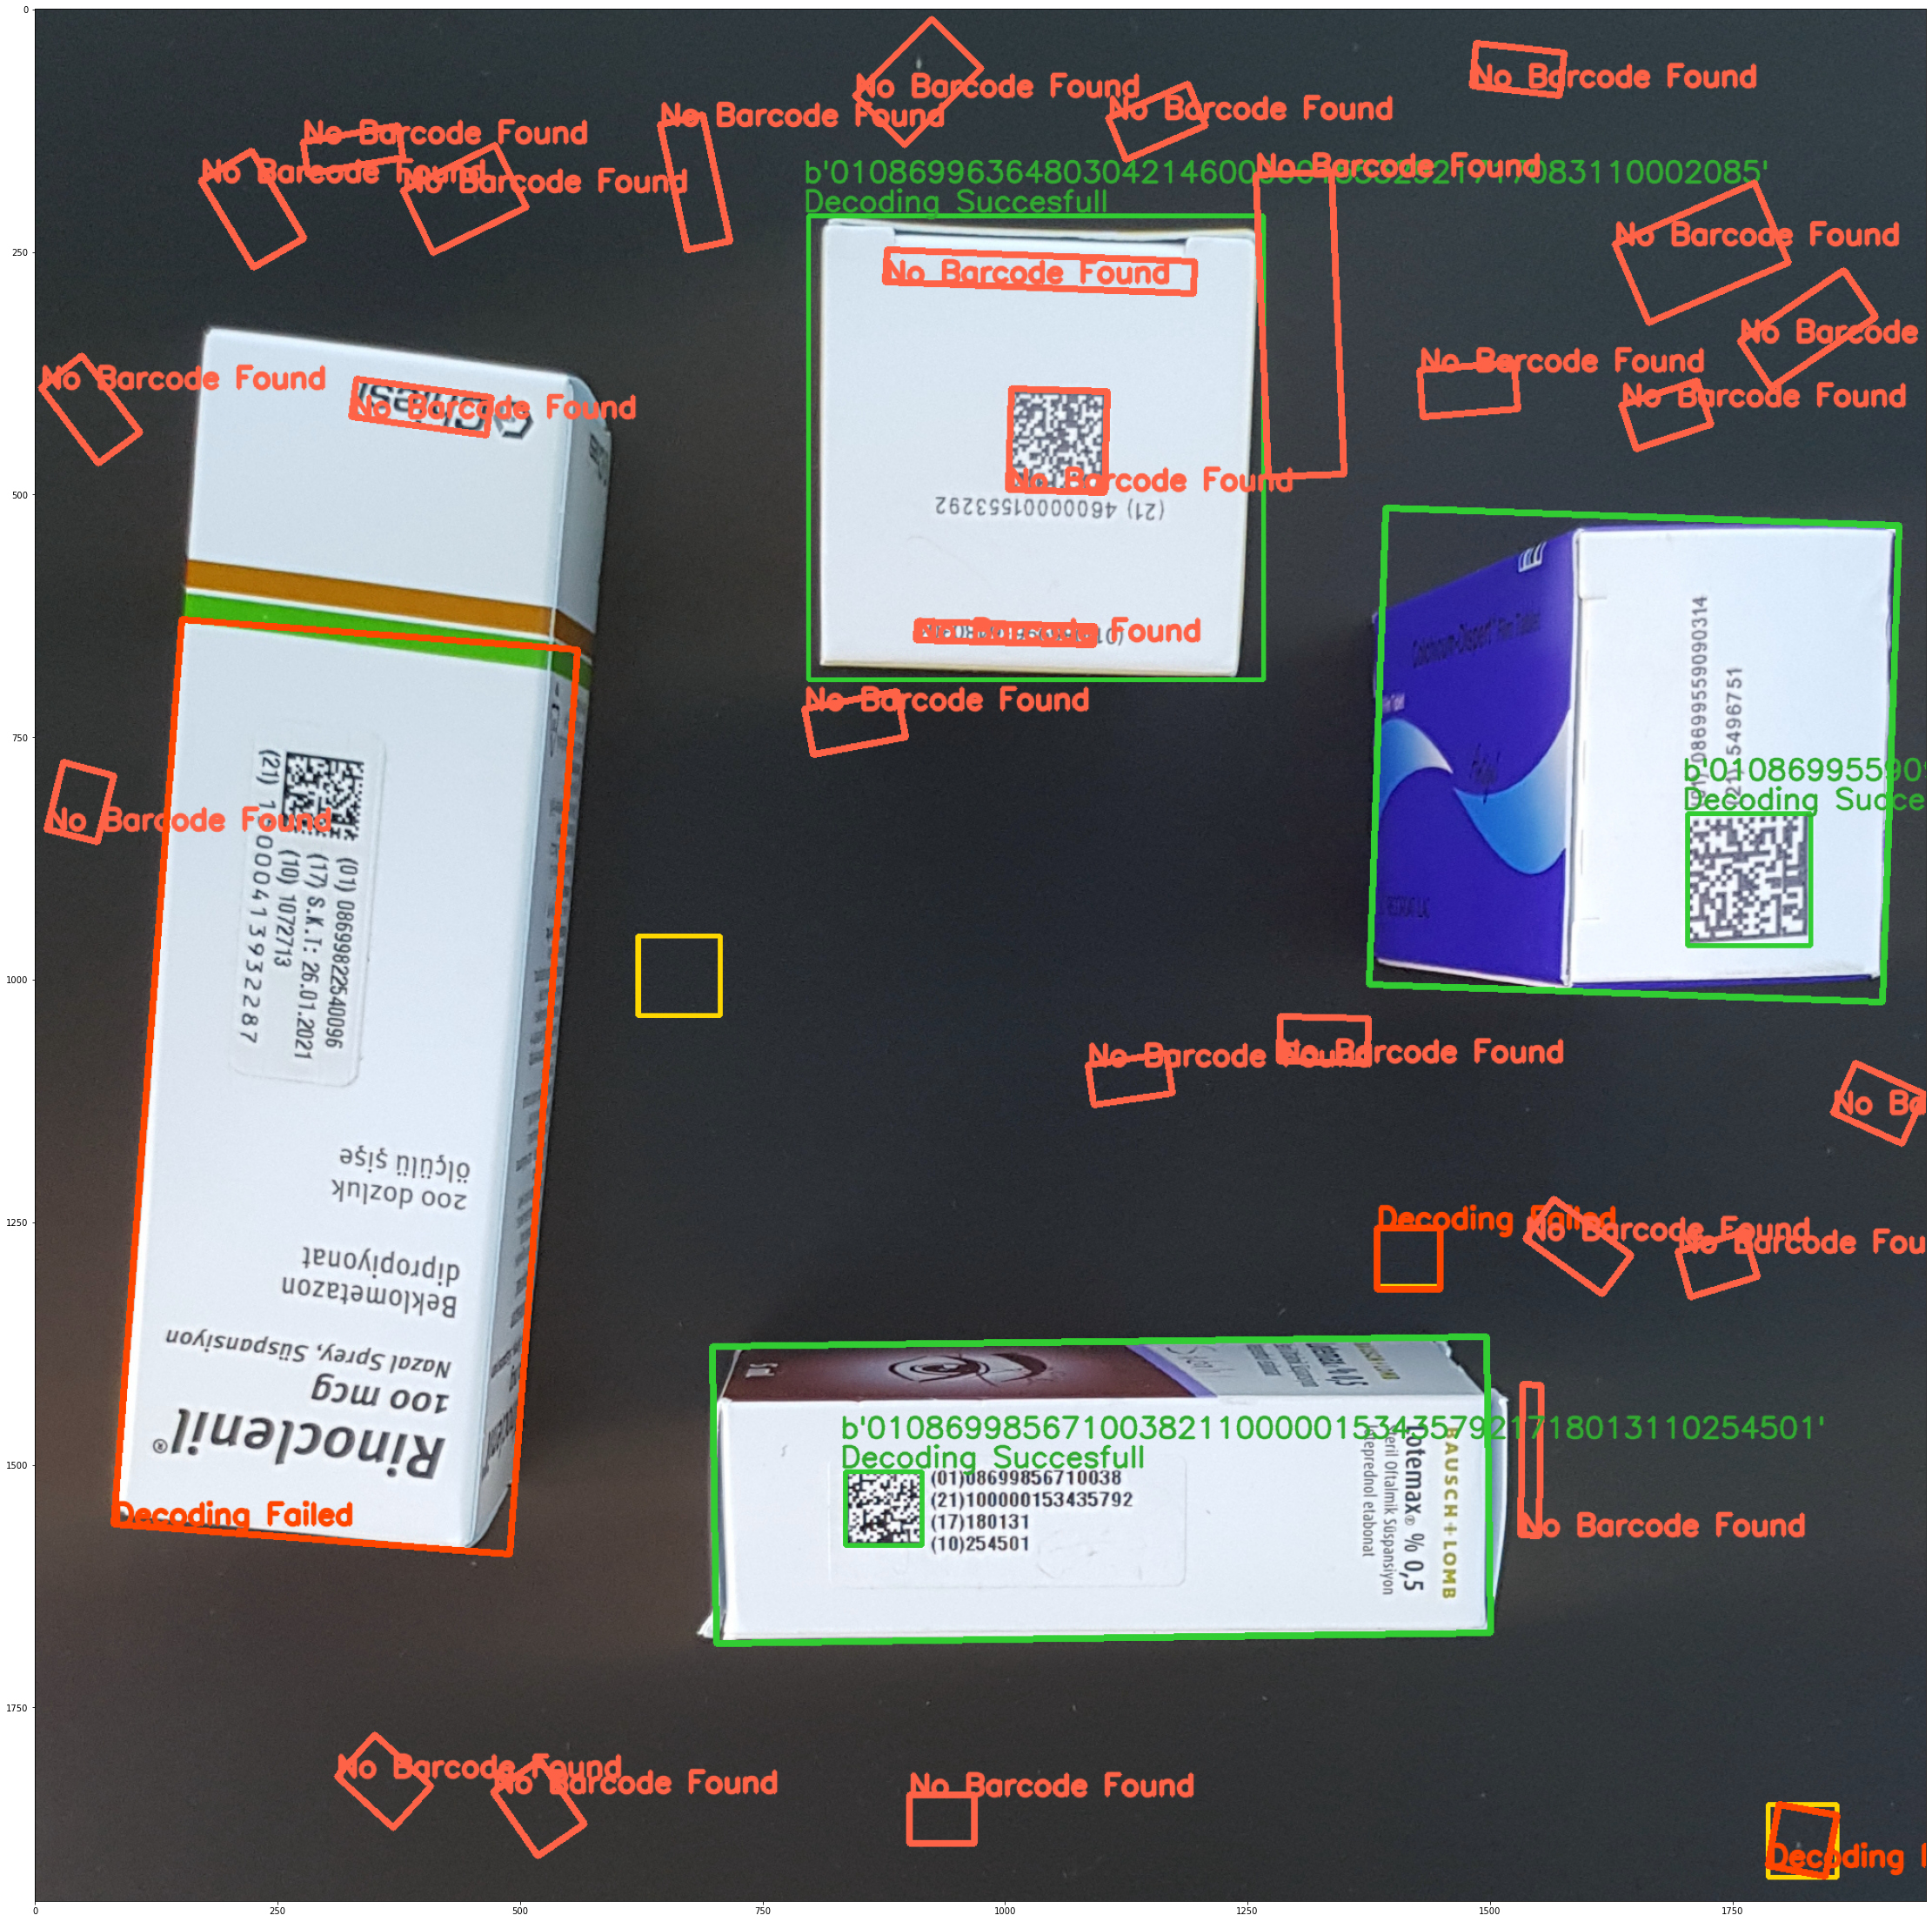

In [47]:
path1 = 'C:/Users/User/Desktop/Box_and_Barcode_Detector/images/easier/a.jpg'
frame = cv2.imread(path1)


image_h, image_w, _ =frame.shape
        
filtered_frame, contours = processFrame(frame)
        
boxes = processContours( contours, area_threshold, aspect_ratio_threshold, \
                                 irregularity_threshold, adjacency_threshold, image_h, image_w  )
        
newFrame = decodeDataMatrices( frame, filtered_frame, boxes )
        
plt.figure(figsize=(40,40))
plt.imshow(newFrame)
cv2.imwrite('C:/Users/User/Desktop/Box_and_Barcode_Detector/images/res2.jpg',newFrame)